<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Interpreting a leaf identification model with LIME
This notebook demonstrates the use of DIANNA with the LIME timeseries method on the coffee dataset.

LIME (Local Interpretable Model-agnostic Explanations) is an explainable-AI method that aims to create an interpretable model that locally represents the classifier. For more details see the [LIME paper](https://arxiv.org/abs/1602.04938).

*NOTE*: This tutorial is still work-in-progress, the final results need to be improved by tweaking the LIME parameters

#### 1. Imports and paths

In [1]:
import os
import pandas as pd
import numpy as np
from dianna import visualization
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import onnx
import onnxruntime as ort
import dianna

np.random.seed(0)

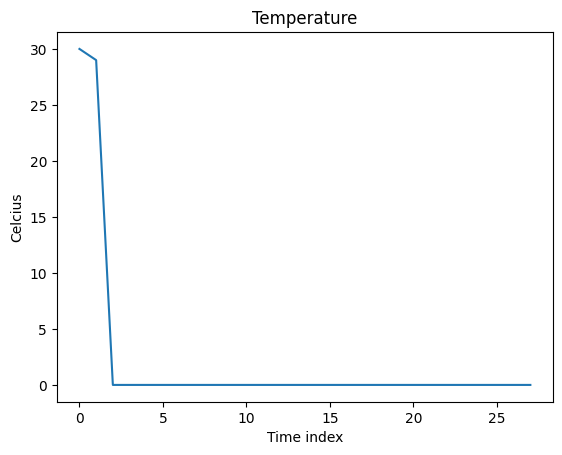

In [26]:
# make up a weather dataset with extrems
cold_with_2_hot_days = np.expand_dims(np.array([30, 29] + list(np.zeros(26))) , axis=1)
data_extreme = cold_with_2_hot_days
fig = plt.figure()
plt.plot(data_extreme)
plt.xlabel("Time index")
plt.ylabel("Celcius")
plt.title("Temperature")
plt.show()

In [3]:
# We define a threshold for the model to make decisions
# The label is ["summer", "winter"]
threshold = 14

def run_expert_model(data):
    is_summer = np.mean(np.mean(data, axis=1), axis=1) > threshold
    number_of_classes = 2
    number_of_instances = data.shape[0]
    result = np.zeros((number_of_instances ,number_of_classes))
    result[is_summer] = [1.0, 0.0]
    result[~is_summer] = [0.0, 1.0]
    return result

In [31]:
# we use the threshold to mask the data
def input_train_mean(_data):
    return threshold

In [32]:
exp = dianna.explain_timeseries(run_expert_model, timeseries_data=data_extreme, method='lime',
                                labels=[0, 1], class_names=["summer", "winter"], num_features=len(data_extreme),
                                num_samples=1000, num_slices=len(data_extreme), distance_method='cosine')

/tmp/ipykernel_10202/3463153371.py:4: RuntimeWarning: invalid value encountered in divide
  zero_to_one = (data - np.min(data)) / (np.max(data) - np.min(data))


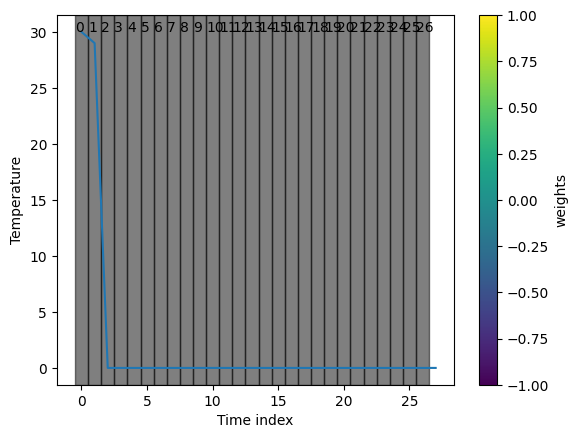

<AxesSubplot: xlabel='Time index', ylabel='Temperature'>

In [41]:
# Normalize the explanation scores for the purpose of visualization
def normalize(data):
    """Squash all values into [-1,1] range."""
    zero_to_one = (data - np.min(data)) / (np.max(data) - np.min(data))
    return 2*zero_to_one -1

local_exp = exp.local_exp[1]
local_exp_list = [i[1] for i in local_exp]

heatmap_channel = normalize(local_exp_list)
segments = []
for i in range(len(heatmap_channel) - 1):
    segments.append({
        'index': i,
        'start': i - 0.5,
        'stop': i + 0.5,
        'weight': heatmap_channel[i]})
visualization.plot_timeseries(range(len(heatmap_channel)), data_extreme,
                              segments, xlabel="Time index", ylabel="Temperature",
                              show_plot=True)

#### 2. Loading the data

In [2]:
# Load weather dataset
fname = "weather_prediction_dataset.csv"
if os.path.isfile(fname):
    data = pd.read_csv(fname)
else:
    data = pd.read_csv(f"https://zenodo.org/record/5071376/files/{fname}?download=1")
data.describe()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
count,3.654000e+03,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,...,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2.004568e+07,6.520799,5.418446,0.745107,1.017876,1.330380,0.234849,4.661193,11.022797,6.989135,...,5.104215,11.470635,3.677258,0.781872,1.016639,1.369787,0.186100,12.205802,7.860536,16.551779
std,2.874287e+04,3.450083,2.325497,0.107788,0.007962,0.935348,0.536267,4.330112,7.414754,6.653356,...,7.250744,8.950217,1.519866,0.115572,0.018885,0.926472,0.422151,6.467155,5.692256,7.714924
min,2.000010e+07,1.000000,0.000000,0.380000,0.985600,0.050000,0.000000,0.000000,-9.300000,-16.000000,...,-19.700000,-14.500000,0.700000,0.330000,0.000300,0.050000,0.000000,-6.200000,-13.000000,-3.100000
25%,2.002070e+07,4.000000,4.000000,0.670000,1.013300,0.530000,0.000000,0.500000,5.300000,2.000000,...,0.000000,4.100000,2.600000,0.700000,1.012100,0.550000,0.000000,7.600000,3.700000,10.800000
50%,2.004567e+07,7.000000,6.000000,0.760000,1.017700,1.110000,0.000000,3.600000,11.400000,7.300000,...,5.000000,11.000000,3.400000,0.800000,1.017300,1.235000,0.000000,12.300000,8.300000,16.600000
75%,2.007070e+07,10.000000,7.000000,0.830000,1.022700,2.060000,0.210000,8.000000,16.900000,12.400000,...,11.200000,19.000000,4.600000,0.870000,1.022200,2.090000,0.160000,17.200000,12.300000,22.400000
max,2.010010e+07,12.000000,8.000000,0.980000,1.040800,3.550000,7.570000,15.300000,29.000000,20.800000,...,21.200000,32.900000,10.800000,1.000000,1.041400,3.560000,6.200000,31.200000,22.600000,39.800000


In [3]:

# select only data from De Bilt
columns = [col for col in data.columns if col.startswith('DE_BILT') and col.endswith('temp_max')]#[:9]
data_debilt = data[columns]
data_debilt.describe()

,DE_BILT_temp_max
count,3654.000000
mean,14.798604
std,7.210740
min,-4.700000
25%,9.200000
50%,14.900000
75%,20.200000
max,35.700000


In [4]:
# find where the month changes
idx = np.where(np.diff(data['MONTH']) != 0)[0]
# idx contains the index of the last day of each month, except for the last month.
# of the last month only a single day is recorded, so we discard it.

nmonth = len(idx)
# add start of first month
idx = np.insert(idx, 0, 0)
ncol = len(columns)
# create single object containing each timeseries
# for simplicity we truncate each timeseries to the same length, i.e. 28 days
nday = 28
data_ts = np.zeros((nmonth, nday, ncol))
for m in range(nmonth):
    data_ts[m] = data_debilt[idx[m]:idx[m+1]][:28]
    
print(data_ts.shape)

(120, 28, 1)


In [5]:
# the labels are based on the month of each timeseries, in range 1 to 12
months = (np.arange(nmonth) + data['MONTH'][0] - 1) % 12 + 1

# one class per meteorological season
labels = np.zeros_like(months, dtype=int)
spring = (3 <= months) & (months <= 5)   # mar - may
summer = (6 <= months) & (months <= 8)   # jun - aug
autumn = (9 <= months) & (months <= 11)  # sep - nov
winter = (months <= 2) | (months == 12)  # dec - feb

labels[spring] = 0
labels[summer] = 1
labels[autumn] = 2
labels[winter] = 3

target = pd.get_dummies(labels)

classes = ['spring', 'summer', 'autumn', 'winter']
nclass = len(classes)

target.describe()

,0,1,2,3
count,120.000000,120.000000,120.000000,120.000000
mean,0.250000,0.250000,0.250000,0.250000
std,0.434828,0.434828,0.434828,0.434828
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.250000,0.250000,0.250000,0.250000
max,1.000000,1.000000,1.000000,1.000000


In [6]:
classes = ['summer', 'winter']
nclass = 2
labels[summer] = 0
labels[winter] = 1
target = pd.get_dummies(labels[summer + winter])
data_ts = data_ts[summer + winter]

#### 3. Training the Model

In [7]:
data_trainval, data_test, target_trainval, target_test = train_test_split(data_ts, target, stratify=target, random_state=0, test_size=.12)
data_train, data_val, target_train, target_val = train_test_split(data_trainval, target_trainval, stratify=target_trainval, random_state=0, test_size=.12)
print(data_train.shape, data_val.shape, data_test.shape)

(45, 28, 1) (7, 28, 1) (8, 28, 1)


In [8]:
# onnx model available on surf drive
# path to ONNX model
onnx_file = 'models/season_prediction_model_temp_max_binary.onnx'

# verify the ONNX model is valid
onnx_model = onnx.load(onnx_file)
onnx.checker.check_model(onnx_model)

def run_model(data):
    # model must receive input in the order of [batch, timeseries, channels]
    # data = data.transpose([0,2,1])
    # get ONNX predictions
    sess = ort.InferenceSession(onnx_file)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    onnx_input = {input_name: data.astype(np.float32)}
    pred_onnx = sess.run([output_name], onnx_input)[0]
    print(f'mean:{np.mean(data)}, prediction:{pred_onnx}')
    
    return pred_onnx

In [9]:
# We can use this 'expert' model instead of a trained model. This expert model decides it's summer if the mean temp is
# above some threshold, and winter in other cases.

def run_expert_model(data):
    is_summer = np.mean(np.mean(data, axis=1), axis=1) > 14
    print(f'{is_summer=}')
    number_of_classes = 2
    number_of_instances = data.shape[0]
    result = np.zeros((number_of_instances ,number_of_classes))
    result[is_summer] = [1.0, 0.0]
    result[~is_summer] = [0.0, 1.0]
    return result

In [10]:
idx = 6 # explained instance
data_instance = data_test[idx][np.newaxis, ...]
# precheck ONNX predictions
pred_onnx = run_expert_model(data_instance)
pred_class = classes[np.argmax(pred_onnx)]
print("The predicted class is:", pred_class)
print("The actual class is:", classes[np.argmax(target_test.iloc[idx])])
input_image = data_instance[0]
print(input_image.T.shape, input_image.T)

is_summer=array([False])
The predicted class is: winter
The actual class is: winter
(1, 28) [[8.1 8.7 9.6 9.4 7.4 9.1 7.4 8.1 7.  4.3 4.4 2.6 3.6 4.  5.4 6.9 7.5 8.6
  5.6 6.1 7.8 6.1 4.4 0.9 2.8 5.5 3.8 5.9]]


In [11]:
series = np.squeeze(input_image)
series.shape

(28,)

#### 3. Applying LIME with DIANNA

In [12]:
#inputs for Lime
class_names = ['summer', 'winter']
num_features = 10
num_slices = len(input_image)

In [13]:
#Run explainer from dianna class
explainer = lime_timeseries.LimeTimeseries()
exp = explainer.explain(run_model, series, labels=[0,1], class_names=class_names, num_features=num_features, num_samples=100, num_slices=num_slices, method='cosine')

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Invalid rank for input: input_3:0 Got: 2 Expected: 3 Please fix either the inputs or the model.

#### 4. Plot results 

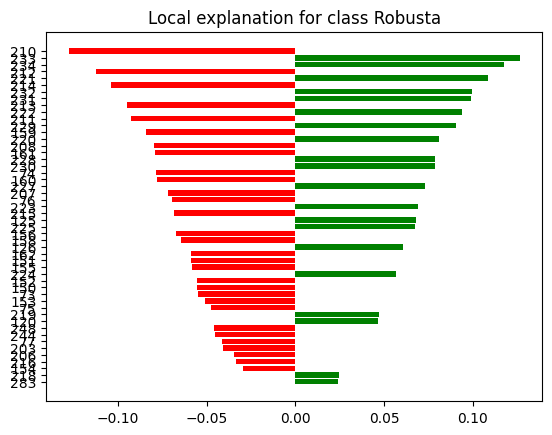

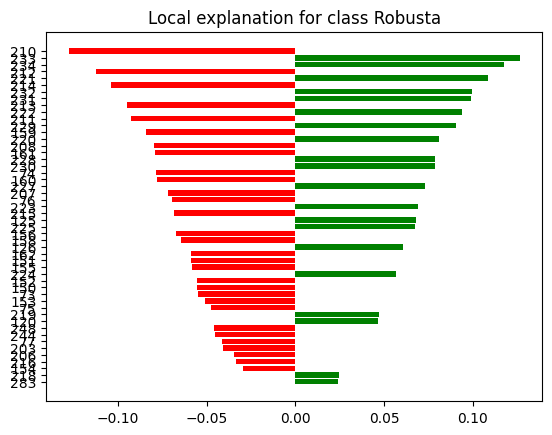

In [6]:
import matplotlib.pyplot as plt
exp.as_pyplot_figure()

1


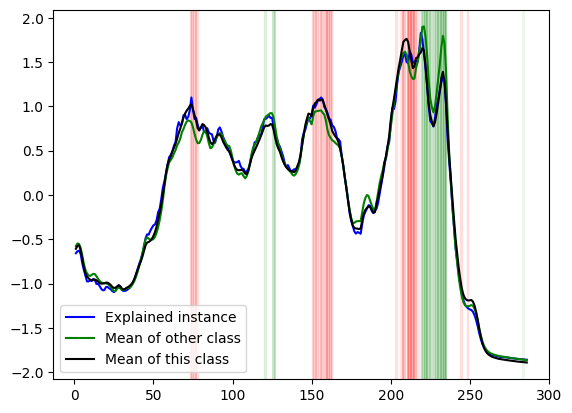

In [7]:
import math
values_per_slice = math.ceil(len(series) / num_slices)
print (values_per_slice)
plt.plot(series, color='b', label='Explained instance')
plt.plot(coffee_test_x.iloc[15:,:].mean(), color='green', label='Mean of other class')
plt.plot(coffee_test_x.iloc[:14,:].mean(), color='black', label='Mean of this class')
plt.legend(loc='lower left')

for i in range(num_features):
    feature, weight = exp.as_list()[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    color = 'red' if weight < 0 else 'green' 
    plt.axvspan(start , end, color=color, alpha=abs(weight*2))
plt.show()

#### Functions to run lime for time-series - explicitly written here until lime_timeseries is finalised in DIANNA

In [9]:
#Mask data from dianna functions
from dianna.utils.maskers import generate_masks
from dianna.utils.maskers import mask_data
masks = generate_masks(series, 10, p_keep=0.9)
masked = mask_data(series, masks, mask_type='mean')

In [ ]:
#Domain Mapper for use in Lime
class TSDomainMapper(explanation.DomainMapper):
    def __init__(self, signal_names, num_slices, is_multivariate):
        """Init function.
        Args:
            signal_names: list of strings, names of signals
        """
        self.num_slices = num_slices
        self.signal_names = signal_names
        self.is_multivariate = is_multivariate
        
    def map_exp_ids(self, exp, **kwargs):
        # in case of univariate, don't change feature ids
        if not self.is_multivariate:
            return exp
        
        names = []
        for _id, weight in exp:
            # from feature idx, extract both the pair number of slice
            # and the signal perturbed
            nsignal = int(_id / self.num_slices)
            nslice = _id % self.num_slices
            signalname = self.signal_names[nsignal]
            featurename = "%d - %s" % (nslice, signalname)
            names.append((featurename, weight))
        return names

#Distance calculation
def distance_calc(input_data, masked_data):
        """Calculate distance based on dynamic time warping."""
        # implementation for reference
        # https://github.com/TortySivill/LIMESegment/blob/0a276e30f8d259642521407e7d51d07969169432/Utils/explanations.py#L111
        distance =  sklearn.metrics.pairwise.pairwise_distances(
                        masked, masked[0].reshape([1, -1]),
                        metric = 'cosine').ravel() * 100
        return distance

#### 3. Applying LIME with inbuilt functions

In [75]:
# Things we need to replace/reproduce
kernel_width = 25

distance = distance_calc(input_data=series, masked_data=masked)

verbose=False
explainer = lime_base.LimeBase(kernel, verbose)

predictions = knn.predict_proba(masked) 

domain_mapper = explanation.DomainMapper()
exp = explanation.Explanation(domain_mapper=domain_mapper, class_names=class_names)

for label in labels:
    (exp.intercept[int(label)],
                exp.local_exp[int(label)],
                exp.score,
                exp.local_pred) = explainer.explain_instance_with_data(masked,
                                                    predictions,
                                                    distance,
                                                    label=label,
                                                    num_features=num_features,
                                                    model_regressor = None,
    )

In [11]:
def dtw_distance(input_data, masked_data):
    """Calculate distance based on dynamic time warping."""
    # implementation for reference
    # https://github.com/TortySivill/LIMESegment/blob/0a276e30f8d259642521407e7d51d07969169432/Utils/explanations.py#L111
    distance =  np.asarray([fastdtw(input_data, one_masked_data)[0] for one_masked_data in masked_data])
    return distance

In [35]:
distance = dtw_distance(series, masked_data = masked)

In [36]:
distance

array([22.19070875, 25.71927442, 22.32230542, 23.18545725, 26.43324826,
       26.83284192, 29.09582042, 28.69291358, 22.12334709, 20.95898842])